# Topics:

- Tensorflow with regression

In [1]:

from sklearn import datasets
from sklearn.model_selection import train_test_split

import os
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import tensorflow as tf

from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix
import gc

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

import torch
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torch.nn as nn
from utils.helper import fn_plot_torch_hist, fn_plot_confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Global variables
inpDir = '../input' # Input Stored here
outDir = './ouput' # output Here
modelDir = './models'# to save Models
subDir = 'fashion_mnist' # sub dir by dataset

RANDOM_STATE = 24
np.random.RandomState(seed=RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
rng = np.random.default_rng(seed=RANDOM_STATE)
N_SAMPLE = 1000
ALPHA = 0.001 # LEARNING RATE
TEST_SIZE = 0.2 # 18147 - 56*256
EPOCH = 50 #2200
BATCH_SIZE = 64
LR_FACTOR = 0.1
LR_PATIENCE = 7

In [4]:
# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'medium',
          'axes.titlesize':'medium',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium',
          'savefig.dpi': 300,
          'image.cmap': plt.cm.inferno,
          'image.interpolation': 'none',
          'savefig.bbox' : 'tight',
          'lines.linewidth' : 2,
          'legend.numpoints' : 1
         }

plt.rcParams.update(params)
# To control the display of floating-point numbers when printing arrays. 
np.set_printoptions(precision=3,  # number of decimal places displayed
                    suppress=True) # prevents the use of scientific notation for small numbers
CMAP = plt.cm.coolwarm
# number of columns displayed when printing a DataFrame
pd.set_option("display.max_columns", 8) # maximum number of columns that will be displayed at once
pd.set_option('display.precision', 2) # precision for floating-point numbers when it’s displayed
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## Data

In [5]:
start = -2.1
end = 2.1
delta = 0.01#0.05 #0.0005

In [6]:
# train data

X_train = np.arange(start, end, delta) # train data
y_rnd = np.random.randn(X_train.shape[0]) - 0.5 # NOISE
y_true = 2 * np.square(X_train) + 2 * np.sin(np.pi * X_train) # Signal

y_train = y_rnd + y_true

In [7]:
X_train[:5]

array([-2.1 , -2.09, -2.08, -2.07, -2.06])

In [8]:
y_train[:5]

array([9.031, 6.908, 7.339, 6.643, 6.542])

In [9]:
# test data

X_test = np.arange(start, end+delta, delta*10) # test data, made sparse by *10
y_rnd = np.random.randn(X_test.shape[0]) - 0.5 # NOISE
y_true_test = 2 * np.square(X_test) + 2*np.sin(np.pi * X_test) # Signal

y_test = y_rnd + y_true_test

In [10]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((420,), (420,), (43,), (43,))

In [11]:
num_sample = 131*BATCH_SIZE
X_train = X_train[:num_sample]
y_true = y_true[:num_sample]
y_train = y_train[:num_sample]


In [12]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((420,), (420,), (43,), (43,))

In [13]:
y_true.shape, y_true_test.shape

((420,), (43,))

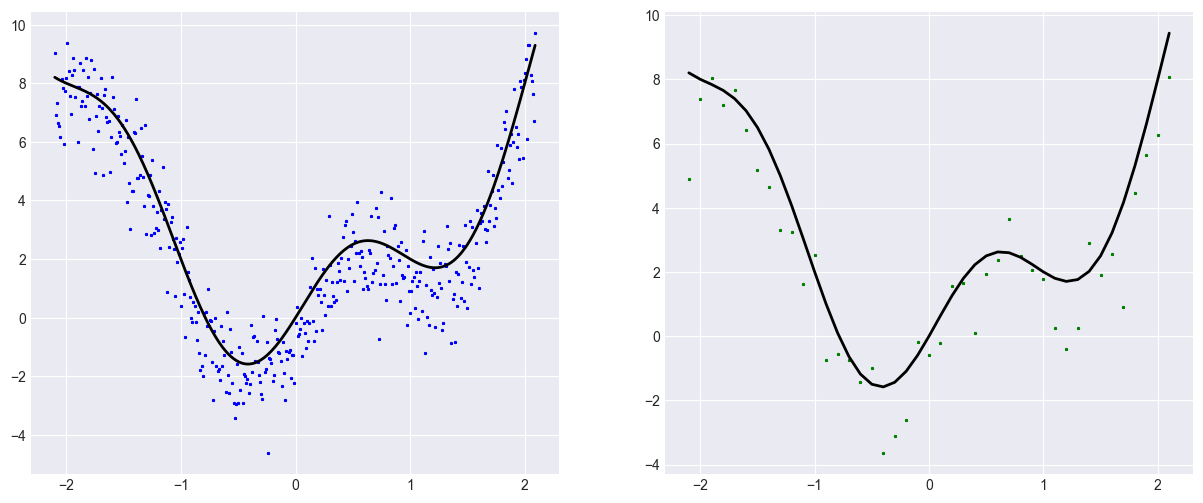

In [14]:
fig, axes = plt.subplots(1, 2)
ax = axes[0]
ax.plot(X_train, y_train, 'b*', markersize=2, label='Train')
ax.plot(X_train, y_true, 'k', markersize=3, label='True')


ax = axes[1]
ax.plot(X_test, y_test, 'g*', markersize=2, label='Test')
ax.plot(X_test, y_true_test, 'k', markersize=3, label='True')


## Model creation

In [15]:
inputs = tf.keras.Input(shape=(1,), name = 'input')
x = tf.keras.layers.Dense(128, 
                         activation = tf.keras.activations.relu,
                          #kernel_initializer=initializer,
                         name = 'fc_1')(inputs)
x = tf.keras.layers.Dense(64, 
                         activation = tf.keras.activations.relu,
                          #kernel_initializer=initializer,
                         name = 'fc_2')(x)
x = tf.keras.layers.Dense(10, 
                         activation = tf.keras.activations.relu,
                          #kernel_initializer=initializer,
                         name = 'fc_3')(x)

outputs = tf.keras.layers.Dense(1,#kernel_initializer=initializer,
                                name='output')(x)

model = tf.keras.Model(inputs= inputs, outputs = outputs, name ='MNIST')

In [16]:
model.summary()

Model: "MNIST"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_1 (Dense)                    │ (None, 128)            │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_2 (Dense)                    │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_3 (Dense)                    │ (None, 10)             │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,173 (35.83 KB)

 Trainable params: 9,173 (35.83 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
BATCH_SIZE, EPOCH, X_train.shape, y_train.shape, X_test.shape, y_test.shape

(64, 50, (420,), (420,), (43,), (43,))

In [18]:
# Training

model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mae']
)

history = model.fit(x=X_train,
                    y=y_train, 
                    validation_data=[X_test, y_test],
                    batch_size=BATCH_SIZE,
                    epochs= EPOCH,
                    verbose=2
                   )

Epoch 1/50
7/7 - 2s - 228ms/step - loss: 15.2603 - mae: 3.0301 - val_loss: 12.7083 - val_mae: 2.7944
Epoch 2/50
7/7 - 0s - 11ms/step - loss: 13.5748 - mae: 2.8689 - val_loss: 11.3509 - val_mae: 2.6681
Epoch 3/50
7/7 - 0s - 11ms/step - loss: 12.1379 - mae: 2.7240 - val_loss: 10.0141 - val_mae: 2.5299
Epoch 4/50
7/7 - 0s - 11ms/step - loss: 10.6821 - mae: 2.5688 - val_loss: 8.6470 - val_mae: 2.3854
Epoch 5/50
7/7 - 0s - 11ms/step - loss: 9.1752 - mae: 2.4015 - val_loss: 7.2883 - val_mae: 2.2129
Epoch 6/50
7/7 - 0s - 11ms/step - loss: 7.6769 - mae: 2.2244 - val_loss: 6.0761 - val_mae: 2.0352
Epoch 7/50
7/7 - 0s - 11ms/step - loss: 6.3810 - mae: 2.0541 - val_loss: 5.2666 - val_mae: 1.8717
Epoch 8/50
7/7 - 0s - 11ms/step - loss: 5.5195 - mae: 1.9252 - val_loss: 4.9747 - val_mae: 1.8183
Epoch 9/50
7/7 - 0s - 11ms/step - loss: 5.1294 - mae: 1.8515 - val_loss: 4.9561 - val_mae: 1.8165
Epoch 10/50
7/7 - 0s - 10ms/step - loss: 4.9306 - mae: 1.8075 - val_loss: 4.8316 - val_mae: 1.7884
Epoch 11/50

In [19]:
loss_df = pd.DataFrame(history.history)
loss_df.head()

,loss,mae,val_loss,val_mae
0,15.26,3.03,12.71,2.79
1,13.57,2.87,11.35,2.67
2,12.14,2.72,10.01,2.53
3,10.68,2.57,8.65,2.39
4,9.18,2.40,7.29,2.21


<Axes: >

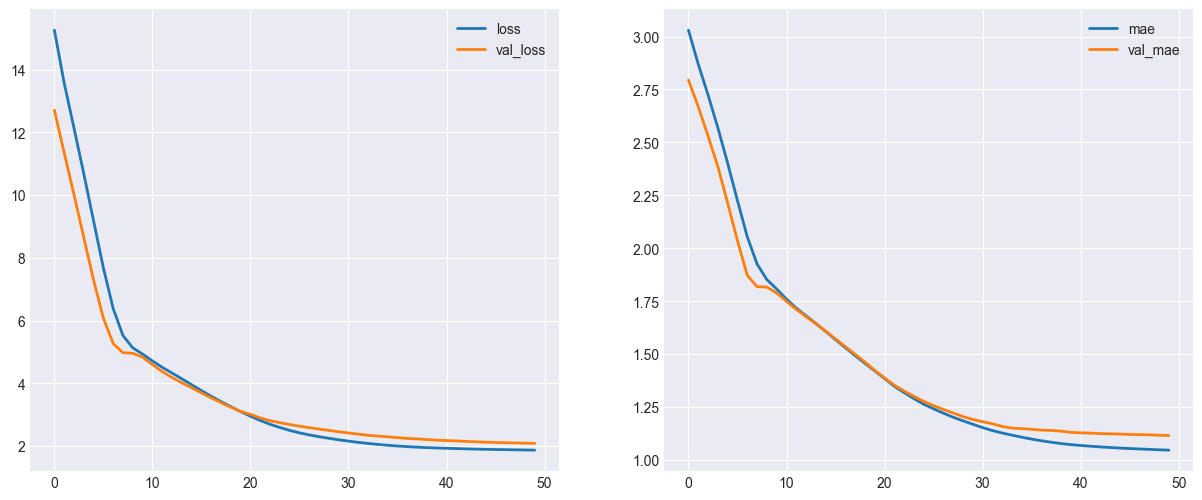

In [20]:
fig, axes = plt.subplots(1,2)
loss_df.plot(y=['loss', 'val_loss'], ax= axes[0])
loss_df.plot(y=['mae', 'val_mae'], ax = axes[1])

In [21]:
y_pred = model.predict(X_test)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


In [22]:
y_pred, y_test

(array([[ 8.88 ],
        [ 8.334],
        [ 7.789],
        [ 7.243],
        [ 6.698],
        [ 6.152],
        [ 5.604],
        [ 5.047],
        [ 4.452],
        [ 3.579],
        [ 2.622],
        [ 1.609],
        [ 0.595],
        [-0.401],
        [-1.226],
        [-1.699],
        [-1.779],
        [-1.791],
        [-1.754],
        [-1.59 ],
        [-1.267],
        [-0.857],
        [-0.414],
        [ 0.116],
        [ 0.412],
        [ 0.61 ],
        [ 0.832],
        [ 1.076],
        [ 1.326],
        [ 1.576],
        [ 1.826],
        [ 2.076],
        [ 2.326],
        [ 2.576],
        [ 2.861],
        [ 3.16 ],
        [ 3.458],
        [ 3.757],
        [ 4.056],
        [ 4.355],
        [ 4.654],
        [ 4.952],
        [ 5.251]], dtype=float32),
 array([ 4.884,  7.376,  8.042,  7.191,  7.676,  6.42 ,  5.165,  4.66 ,
         3.31 ,  3.254,  1.617,  2.53 , -0.732, -0.554, -0.756, -1.425,
        -0.981, -3.645, -3.115, -2.605, -0.173, -0.583, -0.227,  

In [23]:
y_pred1 = [y_pred[i][0] for i in range( len(y_pred) )]
y_pred1

[np.float32(8.879654),
 np.float32(8.334186),
 np.float32(7.788715),
 np.float32(7.2432446),
 np.float32(6.697778),
 np.float32(6.152308),
 np.float32(5.6038804),
 np.float32(5.0469246),
 np.float32(4.4522896),
 np.float32(3.5786633),
 np.float32(2.6222732),
 np.float32(1.6087234),
 np.float32(0.59517384),
 np.float32(-0.40057796),
 np.float32(-1.225704),
 np.float32(-1.6993589),
 np.float32(-1.7787503),
 np.float32(-1.7906207),
 np.float32(-1.7542036),
 np.float32(-1.589681),
 np.float32(-1.2673708),
 np.float32(-0.85692126),
 np.float32(-0.414101),
 np.float32(0.11554266),
 np.float32(0.4115764),
 np.float32(0.609585),
 np.float32(0.8324156),
 np.float32(1.0760912),
 np.float32(1.3256148),
 np.float32(1.5757809),
 np.float32(1.8259468),
 np.float32(2.0761125),
 np.float32(2.3262787),
 np.float32(2.5764446),
 np.float32(2.8608792),
 np.float32(3.1596608),
 np.float32(3.458442),
 np.float32(3.7572234),
 np.float32(4.056005),
 np.float32(4.354786),
 np.float32(4.6535673),
 np.float32(4.

In [24]:
result_df = pd.DataFrame({'pred': y_pred1, 'test': y_test})
result_df['true'] = y_true_test
result_df.head()

,pred,test,true
0,8.88,4.88,8.20
1,8.33,7.38,8.00
2,7.79,8.04,7.84
3,7.24,7.19,7.66
4,6.70,7.68,7.40


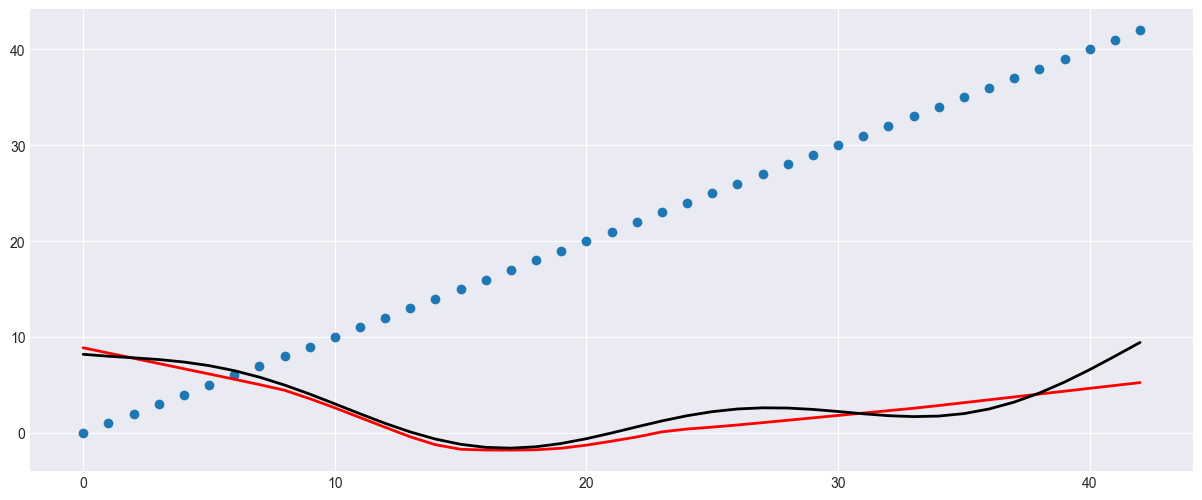

In [25]:
ax = result_df.pred.plot(c='r', label='pred')
result_df.true.plot(c='k', ax=ax, label=True)

plt.scatter(result_df.index, result_df.index)